# Chap 1 Introduction and Data Structure

**Outline**:
* ch1 intro and data structure
* ch2 logistic regression
* ch3 decision trees
* ch4 evaluating a credit risk model


Course focuses on the probability of default

## Components of expected loss (EL)
* Probability of default (PD)
* Exposure at defalult (EAD)  (amount of money due at a default moment )
* Loss given default (LGD)  (amount of the loss if there is a default = a percentage of the EAD)

This gives a formula for an expected loss:

$$EL = PD * EAD * LGD$$

#### Information used by banks

* Application information
    * income
    * marital status
    * ...
* Behavioral information
    * current account balance
    * payment arrears in account history
    * ..


In [14]:
pprint<-function(msg, bc="*"){  ##helper function to pretty prent messages
  mlen <- nchar(msg)
  bord_str <- paste(rep(bc, mlen+4),collapse="")
  msg_bord_str <- paste(rep(bc, 1),collapse="")
  print("")
  print(bord_str)
  print(paste( msg_bord_str,msg, msg_bord_str), sep="")
  print(bord_str)
}

In [15]:
##Exploring the credit data
library(data.table)
library(gmodels)
loan_data<-fread("loan_data.csv",  stringsAsFactors=TRUE)

str(loan_data)
pprint("exploring credit data")

## cross-table to see relation between home_ownership and loan_status
## loan_status 0- no default;  1 - default
CrossTable(loan_data$home_ownership, loan_data$loan_status, prop.r = TRUE,
           prop.c = FALSE, prop.t = FALSE, prop.chisq = FALSE)
paste('we see that  OTHER home ownership has a much higher rate of default')

Classes ‘data.table’ and 'data.frame':	29092 obs. of  8 variables:
 $ loan_status   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 2 1 ...
 $ loan_amnt     : int  5000 2400 10000 5000 3000 12000 9000 3000 10000 1000 ...
 $ int_rate      : num  10.7 NA 13.5 NA NA ...
 $ grade         : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 1 5 2 3 2 2 4 ...
 $ emp_length    : int  10 25 13 3 9 11 0 3 3 0 ...
 $ home_ownership: Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 4 4 4 4 3 4 4 4 4 ...
 $ annual_inc    : num  24000 12252 49200 36000 48000 ...
 $ age           : int  33 31 24 39 24 28 22 22 28 22 ...
 - attr(*, ".internal.selfref")=<externalptr> 
[1] ""
[1] "*************************"
[1] "* exploring credit data *"
[1] "*************************"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  29092 

 
                         | loan_data$loan_status 
loan_data$home_ownership

[1] "we see that  OTHER home ownership has a much higher rate of default"

In [16]:
## see how rate of default is negatively correlated with grade

paste('CrossTable() on grade and loan_status')
CrossTable(loan_data$grade, loan_data$loan_status, prop.r = TRUE,
prop.c = FALSE, prop.t = FALSE, prop.chisq = FALSE)
paste("observe  a correlation  between loan_status and grade.  A - grade is safest ")

[1] "CrossTable() on grade and loan_status"


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  29092 

 
                | loan_data$loan_status 
loan_data$grade |         0 |         1 | Row Total | 
----------------|-----------|-----------|-----------|
              A |      9084 |       565 |      9649 | 
                |     0.941 |     0.059 |     0.332 | 
----------------|-----------|-----------|-----------|
              B |      8344 |       985 |      9329 | 
                |     0.894 |     0.106 |     0.321 | 
----------------|-----------|-----------|-----------|
              C |      4904 |       844 |      5748 | 
                |     0.853 |     0.147 |     0.198 | 
----------------|-----------|-----------|-----------|
              D |      2651 |       580 |      3231 | 
                |     0.820 |     0.180 |     0.111 | 
----------------|-----------|-----------|-----------|
              E |  

[1] "observe  a correlation  between loan_status and grade.  A - grade is safest "

[1] "found outlier cutoff: 140000"


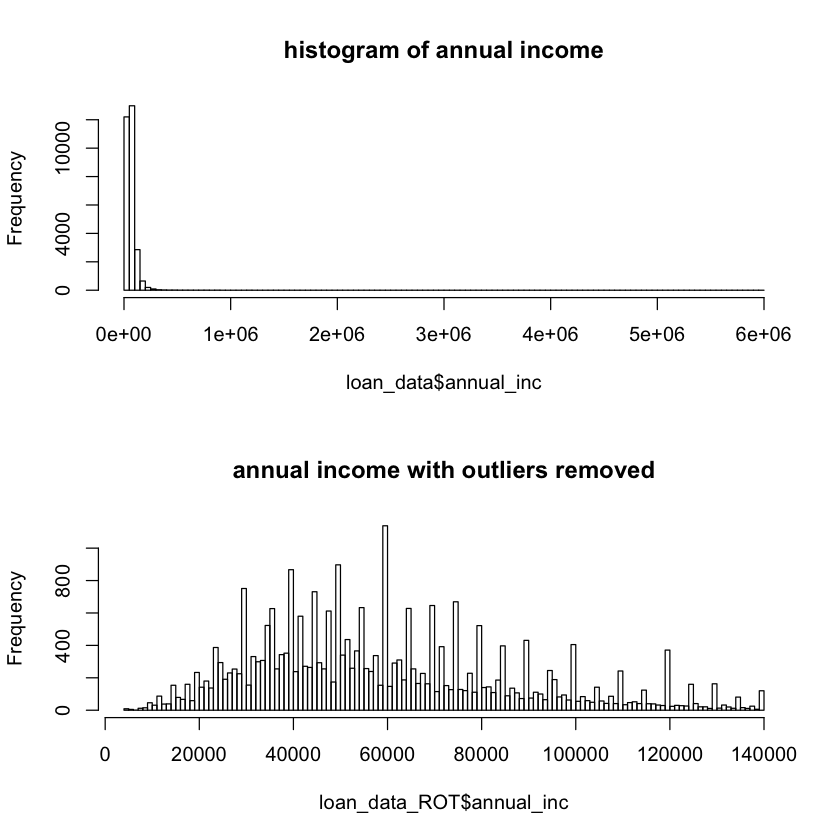

In [26]:
### Histograms (checking for breaks)
# rule of thumb to find number of breaks
n_breaks <- sqrt(nrow(loan_data)) # ~170
par(mfrow=c(2,1))
hist_1<-hist(loan_data$annual_inc, breaks=n_breaks, main="histogram of annual income")

#lets add an outlier cut-off  of the income of 6 mil  with the rule 75%quanile + 1.5 * IQR
outlier_cutoff <- quantile(loan_data$annual_inc, 0.75) + 1.5 * IQR(loan_data$annual_inc)
print(paste("found outlier cutoff:", outlier_cutoff))

index_outlier_ROT <- which(loan_data$annual_inc > outlier_cutoff) #ROT rule of thumb
loan_data_ROT <- loan_data[-index_outlier_ROT,]

nr_breaks <- sqrt(nrow(loan_data_ROT))
hist_2<-hist(loan_data_ROT$annual_inc, breaks=nr_breaks, main="annual income with outliers removed")


### Treating Missing inputs

[1] "number of NAs for int_rate: 2776"
[1] "int_rate NA will be replaced with the median value: 10.99"


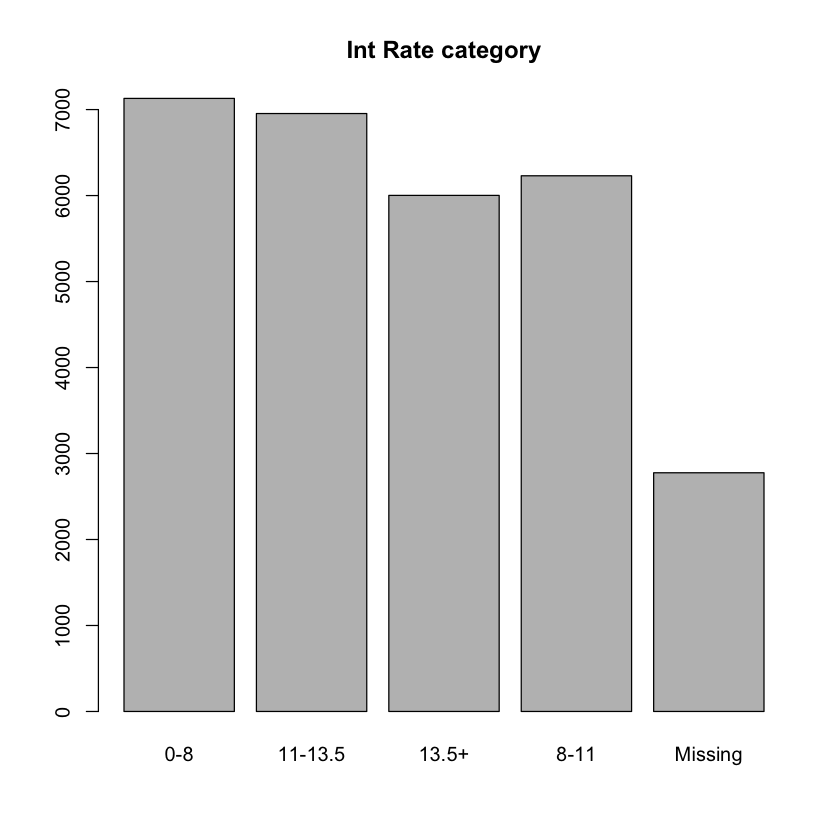

In [32]:
#index of rows with int_rate == NA
na_index<- which(is.na(loan_data$int_rate)==TRUE)
loan_data_delrow_na <- loan_data[-na_index, ]  #strip off this rows from the copied dataset

print(paste("number of NAs for int_rate:",length(na_index)))

#removing entire column
loan_data_delcol_na <- loan_data
# Delete interest rate column from loan_data_delcol_na
loan_data_delcol_na$int_rate <- NULL

##replace int_rate NAs with the median
median_ir <- median(loan_data$int_rate, na.rm=TRUE)
loan_data_replace <- loan_data
# Replace missing interest rates with median
print(paste("int_rate NA will be replaced with the median value:",median_ir))
loan_data_replace$int_rate[na_index] <- median_ir


##introducing a categorical variable ir_cat  with keeping NA in 'Missing' value
loan_data$ir_cat <- rep(NA, length(loan_data$int_rate))

loan_data$ir_cat[which(loan_data$int_rate <= 8)] <- "0-8"
loan_data$ir_cat[which(loan_data$int_rate > 8 & loan_data$int_rate <= 11)] <- "8-11"
loan_data$ir_cat[which(loan_data$int_rate > 11 & loan_data$int_rate <= 13.5)] <- "11-13.5"
loan_data$ir_cat[which(loan_data$int_rate > 13.5)] <- "13.5+"
loan_data$ir_cat[which(is.na(loan_data$int_rate))] <- "Missing"

loan_data$ir_cat <- as.factor(loan_data$ir_cat)

# Look at your new variable using plot()
plot(loan_data$ir_cat, main="Int Rate category")


### Data splitting for training and test set

In [36]:
set.seed(567)

loan_data <- loan_data[1:29091,] #get rid of last point

# Store row numbers for training set: index_train
index_train <- sample(1:nrow(loan_data), 2/3*nrow(loan_data) )

# Create training set: training_set
training_set <- loan_data[index_train, ]

# Create test set: test_set
test_set <- loan_data[-index_train,]

In [34]:
nrow(loan_data)

[1] 29092

### confusion matrix

In [38]:
#for now hadcode the model_pred 
model_pred <- c(1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,1,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,0,1,1,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,1,1,0,1,1,0,1,0,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,0,1,1,0,1,1,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0,1,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,1,1,0,0,0,1,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,1,1,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0)

conf_matrix <-  table(test_set$loan_status, model_pred)

print('confusion matrix')
conf_matrix


print("Compute classification accuracy")
sum(diag(conf_matrix)) / sum(conf_matrix)

print("Compute sensitivity")
conf_matrix[2,2] / (conf_matrix[2,2] + conf_matrix[2,1])


[1] "confusion matrix"


   model_pred
       0    1
  0 6077 2573
  1  703  344

[1] "Compute classification accuracy"


[1] 0.6621636

[1] "Compute sensitivity"


[1] 0.3285578

# Chap 2. Logistic Regression Model